In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import kagglehub
import gc

c:\Users\kadyr\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def load_yelp_data(max_records=5000):
    try:
        dataset_path = kagglehub.dataset_download("omkarsabnis/yelp-reviews-dataset")

        for filename in os.listdir(dataset_path):
            if filename.endswith(".csv"):
                csv_file = os.path.join(dataset_path, filename)
                break
        else:
            raise FileNotFoundError("CSV файл не найден в директории загруженного датасета.")

        df = pd.read_csv(csv_file, nrows=max_records)
        print(f"Датасет загружен успешно. Размер: {df.shape}")

        texts = df['text'].str.lower().values
        del df
        gc.collect()
        return texts
    except Exception as e:
        print(f"Ошибка при загрузке датасета: {e}")
        return ["this is a great restaurant", "the food was amazing", "service was terrible",
                "I would recommend this place to anyone", "the ambiance was nice but the food was not good"]

In [ ]:
# Шаг 2: Предобработка текста с батчами для снижения потребления памяти
def preprocess_text(texts, max_sequence_length=20, max_words=3000, max_sequences=30000):
    print(f"Используем {len(texts)} отзывов для обучения")

    tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(texts)

    total_words = min(max_words, len(tokenizer.word_index) + 1)
    print(f"Общее количество уникальных слов в словаре: {total_words}")

    input_sequences = []
    sequence_count = 0

    for line in texts:
        if not line or not isinstance(line, str):
            continue

        token_list = tokenizer.texts_to_sequences([line])[0]
        if not token_list:
            continue

        for i in range(1, min(len(token_list), max_sequence_length)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
            sequence_count += 1

            if sequence_count >= max_sequences:
                break

        if sequence_count >= max_sequences:
            break

    print(f"Создано {len(input_sequences)} последовательностей")

    # Выравниваем последовательности
    max_seq_len = min(max([len(seq) for seq in input_sequences]), max_sequence_length)
    padded_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='pre')

    # Разделяем на входные и выходные данные для LSTM
    X = padded_sequences[:, :-1]
    y = padded_sequences[:, -1]  # Используем sparse_categorical_crossentropy

    X = X.astype(np.float32)

    return X, y, tokenizer, max_seq_len, total_words

In [ ]:
def build_model(total_words, max_sequence_len):

    model = Sequential()
    model.add(Embedding(total_words, 32))
    # Уменьшаем размер LSTM слоя
    model.add(LSTM(32))
    model.add(Dropout(0.1))

    model.add(Dense(total_words))
    model.add(tf.keras.layers.Activation('softmax'))

    optimizer = Adam(learning_rate=0.01)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    model.summary()
    return model

In [ ]:
def generate_text(seed_text, next_words, model, tokenizer, max_sequence_len, total_words):

    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]

        if len(token_list) > max_sequence_len-1:
            token_list = token_list[-(max_sequence_len-1):]

        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

        predicted_probs = model.predict(token_list, verbose=0)[0]

        # Простой подход: просто берем слово с наибольшей вероятностью
        predicted_index = np.argmax(predicted_probs)

        # Проверяем, что индекс находится в пределах словаря
        if predicted_index >= total_words:
            continue

        # Получаем слово из индекса с помощью обратного словаря
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break

        # Добавляем предсказанное слово к начальному тексту
        seed_text += " " + output_word

    return seed_text

In [ ]:
def train_with_generator(model, X, y, epochs=10, batch_size=32):
    # Создаем генератор данных
    def data_generator(X, y, batch_size):
        num_samples = len(X)
        while True:
            indices = np.random.permutation(num_samples)
            for i in range(0, num_samples, batch_size):
                batch_indices = indices[i:i + batch_size]
                yield X[batch_indices], y[batch_indices]

    # Обучаем модель с использованием генератора
    steps_per_epoch = len(X) // batch_size
    history = model.fit(
        data_generator(X, y, batch_size),
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        verbose=1
    )

    return history

In [ ]:
# Основная функция
def main():
    max_records = 3000
    max_words = 3000
    max_sequence_length = 20
    max_sequences = 30000
    batch_size = 32
    epochs = 10

    print("Загрузка данных...")
    texts = load_yelp_data(max_records=max_records)

    print("\nПредобработка текста...")
    X, y, tokenizer, max_seq_len, total_words = preprocess_text(
        texts,
        max_sequence_length=max_sequence_length,
        max_words=max_words,
        max_sequences=max_sequences
    )
    print(f"Форма X: {X.shape}, форма y: {y.shape}")
    print(f"Размер X в памяти: {X.nbytes / (1024*1024):.2f} МБ")
    print(f"Размер y в памяти: {y.nbytes / (1024*1024):.2f} МБ")

    # Освобождаем память
    del texts
    gc.collect()

    # Строим модель
    print("\nСоздание модели...")
    model = build_model(total_words, max_seq_len)

    # Обучаем модель
    print("\nОбучение модели...")
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)

    # Визуализация
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.title('Точность модели')
    plt.ylabel('Точность')
    plt.xlabel('Эпоха')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.title('Потери модели')
    plt.ylabel('Потери')
    plt.xlabel('Эпоха')
    plt.tight_layout()
    plt.savefig('training_history.png')

    # Генерация текста с разными начальными фразами
    seed_texts = [
        "the food was",
        "i really enjoyed",
        "this restaurant is",
        "the service was"
    ]

    print("\nГенерация текста на основе разных начальных фраз:")
    for seed in seed_texts:
        generated = generate_text(seed, 10, model, tokenizer, max_seq_len, total_words)
        print(f"\nНачальный текст: '{seed}'")
        print(f"Сгенерированный текст: '{generated}'")

    # Сохранение модели
    model.save('yelp_lstm_model_small.h5')
    print("\nМодель сохранена как 'yelp_lstm_model_small.h5'")

Загрузка данных...
Датасет загружен успешно. Размер: (3000, 10)

Предобработка текста...
Используем 3000 отзывов для обучения
Общее количество уникальных слов в словаре: 3000
Создано 30000 последовательностей
Форма X: (30000, 19), форма y: (30000,)
Размер X в памяти: 2.17 МБ
Размер y в памяти: 0.11 МБ

Создание модели...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Обучение модели...
Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.0786 - loss: 6.1777
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.1250 - loss: 5.2980
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1546 - loss: 4.9290
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1702 - loss: 4.6469
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1819 - loss: 4.4244
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1938 - loss: 4.2343
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2019 - loss: 4.0964
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2130 - loss: 3.9440
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2231 - loss: 3.8409
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2269 - loss: 3.7796

Генерация текста на основе разных начальных фраз:

Начальный текст: 'the food was'
Сгенерированный текст: 'the food wa


Начальный текст: 'the service was'
Сгенерированный текст: 'the service was good and the best <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>'

Модель сохранена как 'yelp_lstm_model_small.h5'


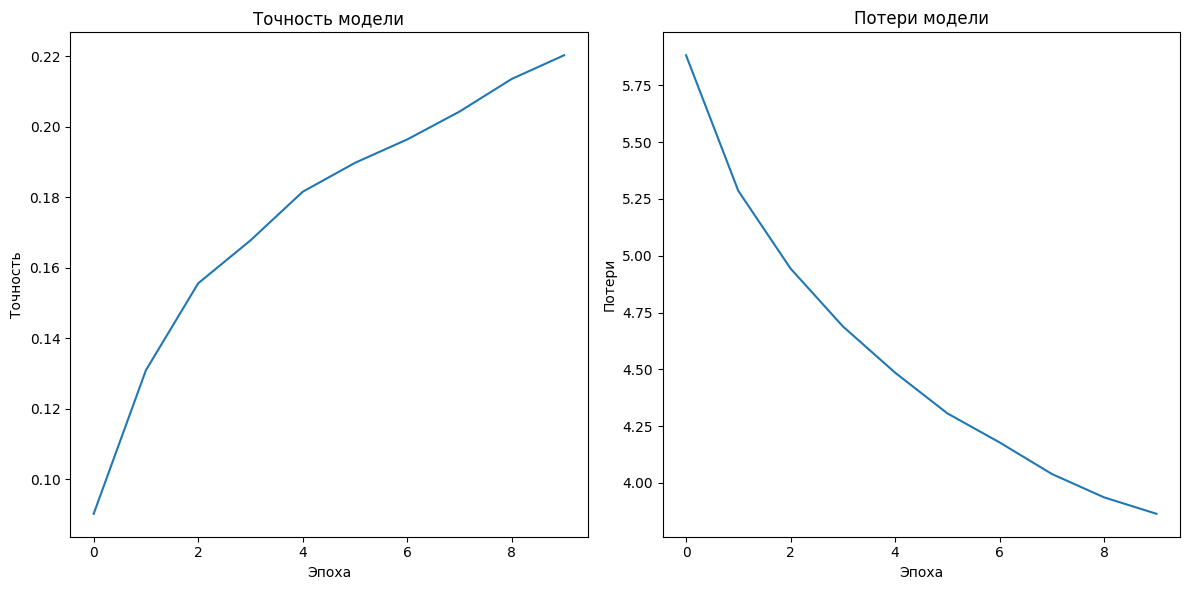

In [ ]:
main()